## Problème 1: Interpolation sur un maillage

Des données en x et y sont fournies dans le fichier ``donnees_geochimiques.csv``.

- Utilise l'interpolation linéaire pour générer une carte des concentrations en uranium.
- Utilise le krigeage pour générer une carte des concentrations en uranium.

- Quelles sont les principales différences?

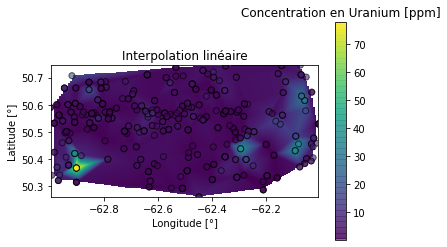

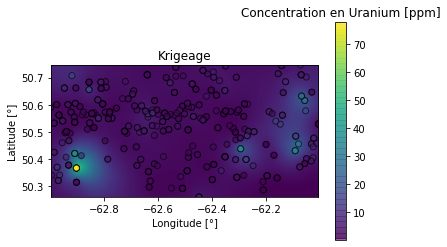

In [1]:
import ulgeostat as ul
import numpy as np
import matplotlib.pyplot as plt
from pykrige import OrdinaryKriging
from scipy.interpolate import griddata

# j'extraie les données
data = np.genfromtxt('donnees_geochimiques.csv', delimiter=',', skip_header=1)
X = data[:,0]
Y = data[:, 1]
U = data[:, 2]

# je m'assure d'avoir l'entièreté du domaine
xmin = X.min()
xmax = X.max()

ymin = Y.min()
ymax = Y.max()

extent = (xmin, xmax, ymin, ymax)

# je crée un grillage linéairement espacé
N = 150
xv = np.linspace(xmin, xmax, N)
yv = np.linspace(ymin, ymax, N)
xv, yv = np.meshgrid(xv, yv, sparse=True)

coords = np.hstack((X[:, None], Y[:, None]))

# interpolation linéaire
interp_lin = griddata(coords, U, (xv, yv), method='linear').reshape((N,N))

plt.imshow(interp_lin, origin='lower', extent=extent, vmin=U.min(), vmax=U.max())
plt.scatter(X, Y, c=U, ec='k', alpha=0.6)
cb = plt.colorbar()
cb.ax.set_title('Concentration en Uranium [ppm]')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.title('Interpolation linéaire')
plt.show()

# krigeage
ok1 = OrdinaryKriging(X, Y, U, variogram_model='spherical', enable_plotting=False)
z1, ss1 = ok1.execute('grid', xv, yv)

plt.imshow(z1, origin='lower', extent=extent, vmin=U.min(), vmax=U.max())
plt.scatter(X, Y, c=U, ec='k', alpha=0.6)
cb = plt.colorbar()
cb.ax.set_title('Concentration en Uranium [ppm]')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.title('Krigeage')
plt.show()


### Quelles sont les principales différences?

L'interpolation linéaire génère une surface passant par tout les points observés. Chacune des valeurs interpolées dépend des valeurs les plus proches et trace un plan droit entre eux. L'interpolation linéaire ne peut donc pas extrapoler à l'extérieur du domaine.

Le krigeage lui prend en compte l'entièreté des observations dans le domaine en compte dans le calcul des valeurs interpolées. Il s'en trouve donc une surface beaucoup plus lisse.

Dans la prochaine cellule, je génère quelques exemples de méthodes d'interpolation. Tu peux afficher et enlever les différentes courbes en cliquant à droite. Tu peux aussi changer le nombre de points d'observation pour voir l'impact sur la courbe interpolée!


<IPython.core.display.Javascript object>


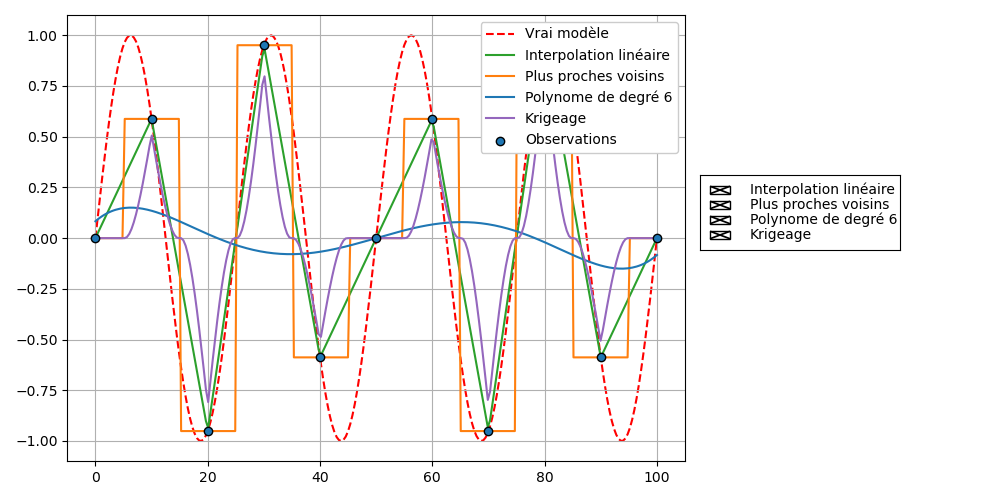

<ipython-input-2-d3f8a000500b>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.7, 1))


In [2]:
%matplotlib notebook
from matplotlib.widgets import CheckButtons


# Exemple des méthodes d'interpolation pour un couple de données x et y

N_points_dobservation = 11 # tu peux changer le nombre de points d'observation

x = np.linspace(0, 100, 250) # le grillage complet
y = np.sin(2*np.pi*x/25)  # le vrai  modèle

X = np.linspace(0, 100, N_points_dobservation) # les points d'observations
Y = np.sin(2*np.pi*X/25)  # les observations

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, label='Observations', ec='k', zorder=10)
plt.plot(x, y, label='Vrai modèle', c='r', ls='dashed', zorder=0)

y_lin = griddata(X, Y, x, method='linear') # interpolation linéaire
y_near = griddata(X, Y, x, method='nearest') # interpolation par les plus proches voisins
y_poly = np.polynomial.Polynomial(np.polyfit(X, Y, deg=6)[::-1])(x) # polynome de degré 6
ok = OrdinaryKriging(X, np.zeros_like(X), Y, variogram_model='spherical', enable_plotting=False) # krigeage
y_krige, var = ok.execute('grid', x, np.array([0.0]))

# affichage sur graphique des différentes courbes
l_lin, = plt.plot(x, y_lin, label='Interpolation linéaire', c='tab:green')
l_near, = plt.plot(x, y_near, label='Plus proches voisins', c='tab:orange')
l_poly, = plt.plot(x, y_poly, label='Polynome de degré 6', c='tab:blue')
l_krig, = plt.plot(x, y_krige.squeeze(), label='Krigeage', c='tab:purple')

plt.grid()
plt.legend(framealpha=1).set_zorder(11)

lines = [l_lin, l_near, l_poly, l_krig]
rax = plt.axes([0.7, 0.5, 0.2, 0.15])
labels = [l.get_label() for l in lines]
vis = [line.get_visible() for line in lines]
check = CheckButtons(rax, labels, vis)

def func(label):
    index = labels.index(label)
    lines[index].set_visible(not lines[index].get_visible())
    plt.draw()

check.on_clicked(func)
plt.tight_layout(rect=(0, 0, 0.7, 1))
plt.show()

# Problème 2: Données d'orientation
Les données dans la liste ``directions`` contiennent les directions de paléocourants observés sur des fossiles. 
- Indique l'orientation moyenne des paléocourants.
- Indique si la distribution est uniforme ou s'il existe une orientation préférentielle.

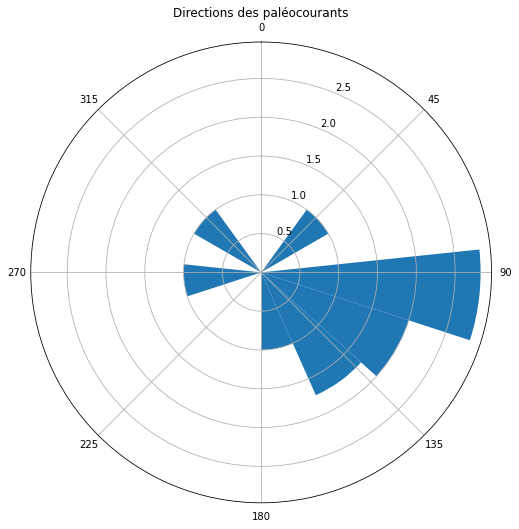

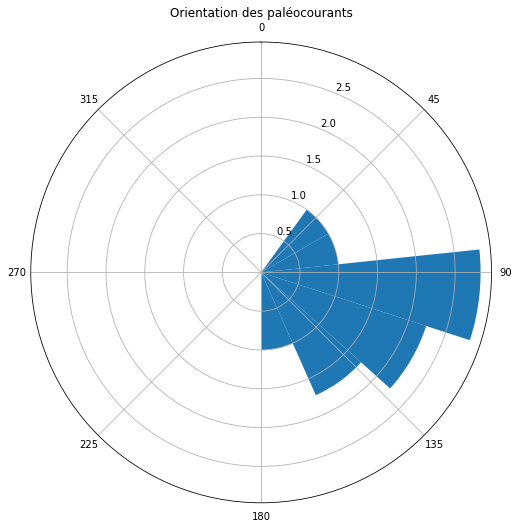

Orientation moyenne: 122.1°
Rbar: 0.92
chi-carré = 38.00


In [42]:
%matplotlib inline
directions = np.array([132, 122, 145, 114, 314, 119, 114, 65, 105, 148, 133, 176, 142, 119, 104, 144, 96, 112, 274])
n = len(directions)


ul.rose(directions, bins=15, fname='Directions des paléocourants')

orientations = directions % 180 # transfert des directions en orientations
ul.rose(orientations, bins=15, fname='Orientation des paléocourants')

# Calcul de l'orientation moyenne
xi = np.sin(orientations * np.pi/180)
yi = np.cos(orientations * np.pi/180)

xr = xi.sum()
yr = yi.sum()

if  (xr > 0.0) & (yr > 0.0) :
    theta_corr = 0.0 
elif (xr > 0.0) & (yr < 0.0):
    theta_corr = np.pi
elif (xr < 0.0) & (yr < 0.0):
    theta_corr = np.pi
elif (xr<0.0) & (yr > 0.0):
    theta_corr = np.pi*2.0
    
theta_mu = np.arctan(xr/yr) + theta_corr
orientation_mu = theta_mu * 180/np.pi

R = np.sqrt(xr**2 + yr**2)
Rbar = R/n
so2 = 1 - Rbar

print(f'Orientation moyenne: {orientation_mu:.1f}°')
print(f'Rbar: {Rbar:.2f}')

k= 0 
nc = int(n/5)
bins = np.arange(0.0,2.0*np.pi,2*np.pi/nc)*180/np.pi
O= np.zeros(nc)
Ej = n/nc

# Déterminer la valeur de chi**2 pour le test 
for j in np.arange(nc)-1:
    for i in np.arange(n):
        if bins[j] <= orientations[i] & (orientations[i]<bins[j+1]): # Classes
            k=k+1
    O[j]=k
    k = 0
    
O[-1] = n-sum(O) # La dernière classe
chi2 = np.sum((O-Ej)**2.0)/Ej # Valeur de notre test chi-carré
print (f"chi-carré = {chi2:.2f}")


# Problème 3: Données temporelles

Le vecteur lits indique la position de lits de bentonite le long d'un forage. Chaque lit indique un évènement volcanique. 

- Indique si la distribution des évènements volcanique est aléatoire.


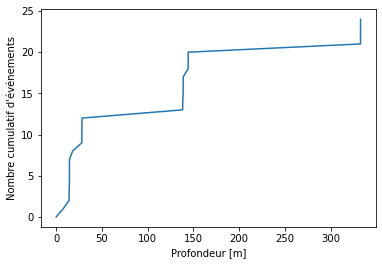

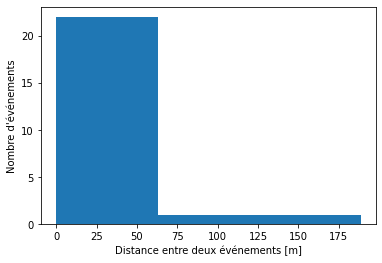

Les tranches sont :
[  0.           7.85041667  15.70083333  23.55125     31.40166667
  39.25208333  47.1025      54.95291667  62.80333333  70.65375
  78.50416667  86.35458333  94.205      102.05541667 109.90583333
 117.75625    125.60666667 133.45708333 141.3075     149.15791667
 157.00833333 164.85875    172.70916667 180.55958333]
Test chi**2 (poisson) = 22.842931304319848


In [137]:
lits = [0.0, 7.77, 14.1, 14.22, 14.47, 14.5, 14.51, 14.55, 18.04, 28.02, 28.12, 28.17, 28.27, 138.28, 138.42, 138.87, 138.87, 138.9, 144.35, 144.35, 144.35, 332.76, 332.77, 332.79, 332.79]

plt.plot(lits, np.arange(len(lits)))
plt.xlabel('Profondeur [m]')
plt.ylabel('Nombre cumulatif d\'événements')
plt.show()
dx = np.diff(lits)

plt.hist(dx, 3)
plt.xlabel('Distance entre deux événements [m]')
plt.ylabel('Nombre d\'événements')
plt.show()

chi2 = ul.chi2_poisson(dx, 24)
print(f'Test chi**2 (poisson) = {chi2}')
